# Imports needed for DQN
## Custom Reward Model

In [1]:
"""
Import Statements: From PyTorch RL Tutorial
Unchanged code from Milestone
"""
import gym
import math
import random
import numpy as np
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nle
from collections import namedtuple, deque

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Internal Imports & Setup

In [2]:
from utils.terminal_stream import TerminalStream
from utils.nle_metrics import NetHackMetricsEnv

# Replay Memory Class
## Used to store a state into a queue (used in policy calculation)

In [3]:
StateTransition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [4]:
"""
This model stores replays of memories as a whole. It also holds the full set, and manages removing old memories.
From PyTorch DQN Tutorial
"""
class ReplayMemory():
    def __init__(self, max_memory):
        self.memory = deque([], maxlen=max_memory)
    
    def push(self, *newExp):
        self.memory.append(StateTransition(*newExp))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN Model, with two Conv2d layers
## Takes the input provided by the dictionary in state

In [5]:
"""
DQN implementation, with convolutional layers, max pooling implemented.
"""
class DQNetwork(nn.Module):
    def __init__(self, n_actions):
        super(DQNetwork, self).__init__()
        self.joe = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding='same'),
            nn.ReLU(), # 21 * 79 * 16
            nn.MaxPool2d(3, padding=(0,1)), # 7 * 27 * 16
            nn.Conv2d(16, 64, kernel_size=3, padding='same'),# 7 * 27 * 64
            nn.ReLU(),
            nn.MaxPool2d(3, padding=(1,0)), # 3 * 9 * 64
            nn.Flatten(),
            nn.Linear(3*9*64, 3*64),
            nn.ReLU(),
            # Hard coded activation layer
            nn.Linear(3*64, n_actions),
        )
        
    def forward(self, x):
        logits = self.joe(x.float())
        return logits

# Training

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
steps_done = 0

# GYM
env = NetHackMetricsEnv('DQN-Final-Valk', character='valkyrie-dwarf')
n_actions = env.action_space.n

In [7]:
policy_net = DQNetwork(n_actions).to(device)
target_net = DQNetwork(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [9]:
def optimize_model(iter_num):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = StateTransition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    if iter_num % 10000 == 0:
        print('Iteration number ' + str(iter_num) + ' loss: ' + str(loss.item()))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Train for a set number of episodes
## 1 Episode = 1 Full gameplay of NetHack
### Either we die, quit or beat the game

In [10]:
def concat_state(state):
    state = np.stack((state['glyphs'], state['chars'], state['colors'], state['specials']))
    state = torch.tensor(np.expand_dims(state, axis=0), device=device)
    return state

Iteration number 10000 loss: 0.037975627928972244
Iteration number 20000 loss: 0.051632627844810486
Iteration number 30000 loss: 0.03856761381030083
Iteration number 40000 loss: 0.04974834993481636
Iteration number 50000 loss: 0.010999109596014023
Iteration number 60000 loss: 0.0074937958270311356
Iteration number 70000 loss: 0.003258123528212309
Iteration number 80000 loss: 0.016598545014858246
Iteration number 90000 loss: 0.0015084786573424935
Iteration number 100000 loss: 0.055712733417749405
Iteration number 110000 loss: 0.0009629405685700476
Iteration number 120000 loss: 0.0001249442429980263
Iteration number 130000 loss: 0.0007837172597646713
Iteration number 140000 loss: 0.0009695252520032227
Iteration number 150000 loss: 0.005253621377050877
Iteration number 160000 loss: 0.022401202470064163
Iteration number 170000 loss: 0.009882329031825066
Iteration number 180000 loss: 0.0367424339056015
Iteration number 190000 loss: 0.004136235918849707
Iteration number 200000 loss: 0.000173

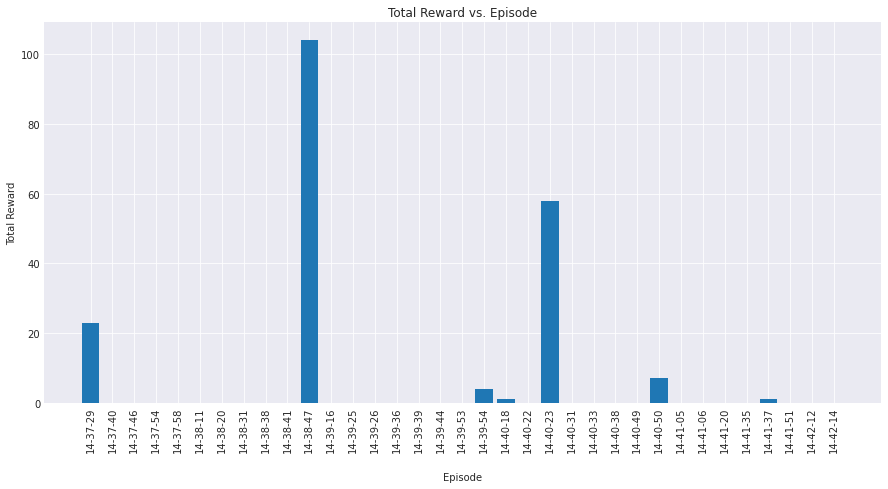

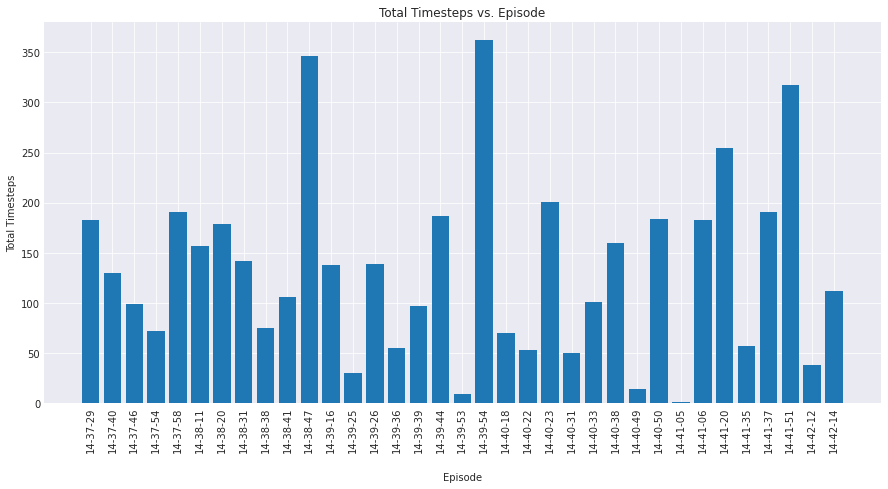

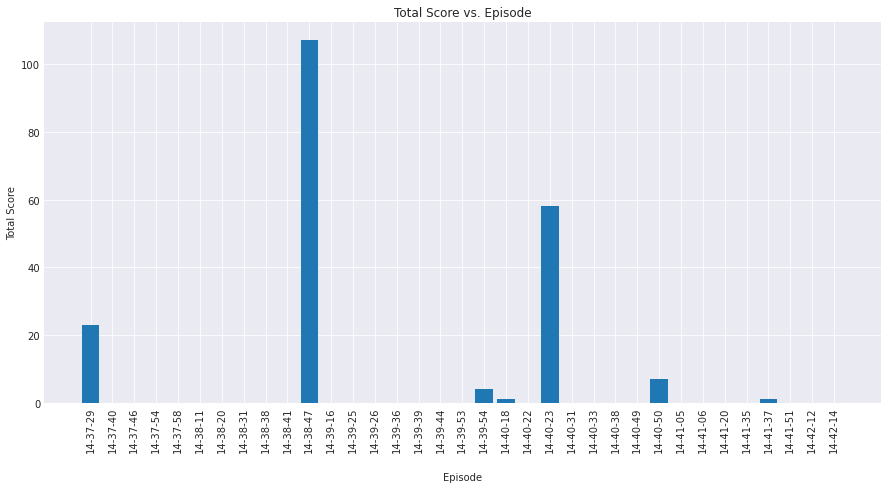

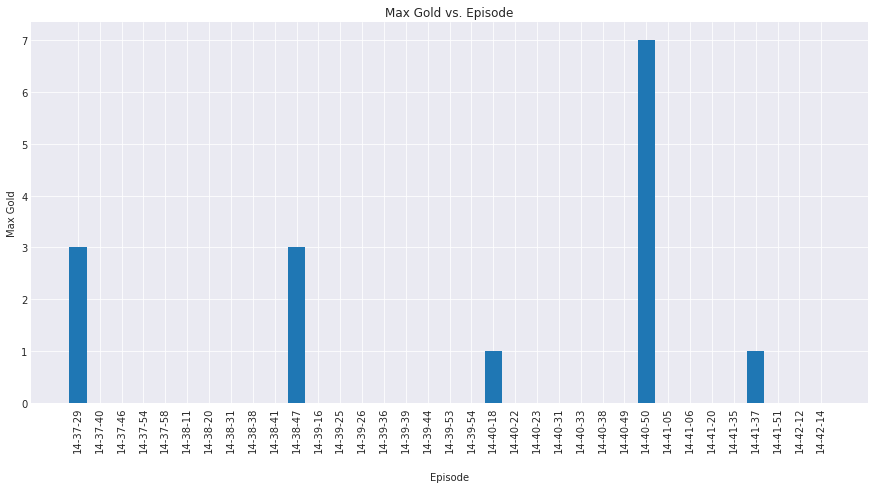

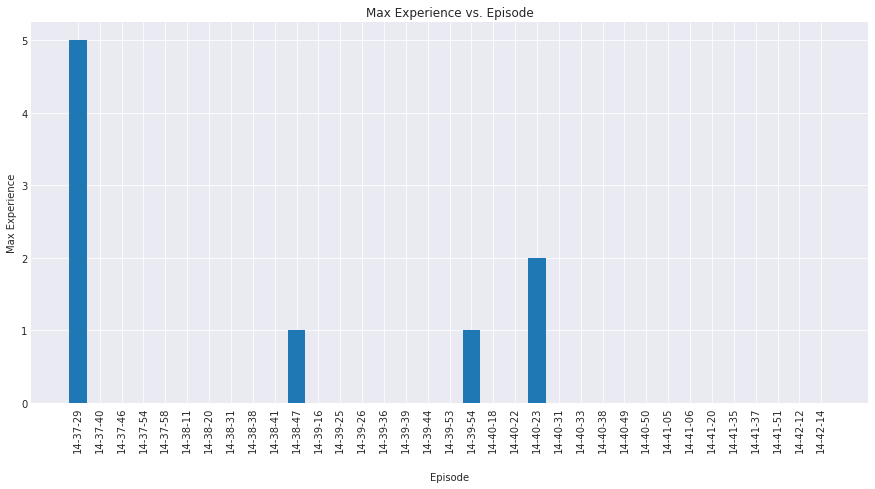

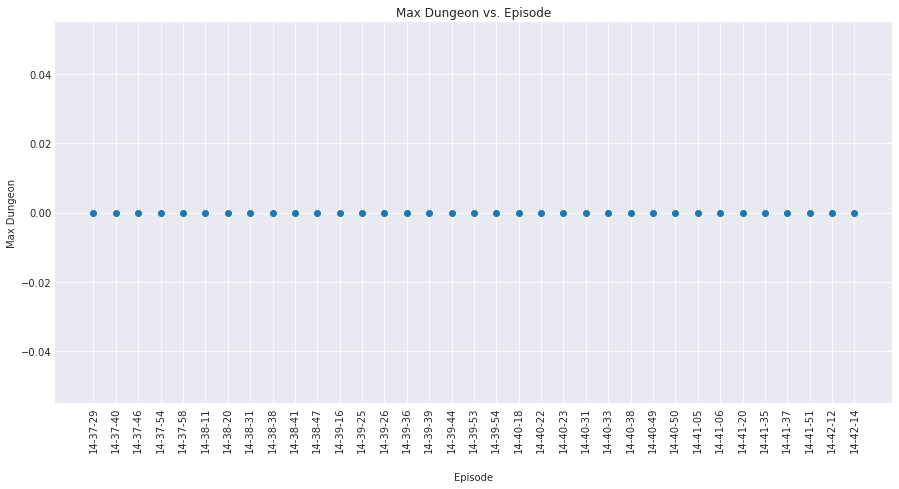

In [11]:
%%time
MAX_STEPS = 1000000

obs = env.reset()

for t in range(MAX_STEPS):
    state = concat_state(obs)
    
    # Select and perform an action
    action = select_action(state)
    obs, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # Keep track of current state and previous states 
    last_state = state
    state = concat_state(obs)

    # Store the transition in memory
    memory.push(last_state, action, state, reward)

    # Perform one step of the optimization (on the policy network)
    optimize_model(t)

    if done:
        obs = env.reset()
    # Update the target network, copying all weights and biases in DQN
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
print('Complete')
env.write_report()

# Save the models
## Continue to train it later, or to load it up when you are testing. 

In [12]:
torch.save(policy_net, 'policy-custom-reward-valk')
torch.save(target_net, 'target-custom-reward-valk')

# Testing (More training for now, another 1,000,000 steps)

In [15]:
env = NetHackMetricsEnv('DQN-Final-Valk-2', character='valkyrie-dwarf')
n_actions = env.action_space.n

In [16]:
"""
Loads the data if there is need for it. 
Should only be ran if we trained without testing and vice versa. 
"""
policy_net = torch.load('policy-custom-reward-valk')
policy_net.eval()
target_net = torch.load('target-custom-reward-valk')
target_net.eval()

DQNetwork(
  (joe): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=(0, 1), dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=(1, 0), dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1728, out_features=192, bias=True)
    (8): ReLU()
    (9): Linear(in_features=192, out_features=45, bias=True)
  )
)

Iteration number 0 loss: 0.005109378136694431
Iteration number 10000 loss: 0.0016539791831746697
Iteration number 20000 loss: 0.0017164347227662802
Iteration number 30000 loss: 0.0016587008722126484
Iteration number 40000 loss: 0.0016610720194876194
Iteration number 50000 loss: 0.0015858612023293972
Iteration number 60000 loss: 0.0016780274454504251
Iteration number 70000 loss: 0.0016343449242413044
Iteration number 80000 loss: 0.0016759114805608988
Iteration number 90000 loss: 0.0016963063972070813
Iteration number 100000 loss: 0.001681288005784154
Iteration number 110000 loss: 0.0016400583554059267
Iteration number 120000 loss: 0.0017465695273131132
Iteration number 130000 loss: 0.0016757715493440628
Iteration number 140000 loss: 0.0016688755713403225
Iteration number 150000 loss: 0.0016845926875248551
Iteration number 160000 loss: 0.0016695494996383786
Iteration number 170000 loss: 0.0016757338307797909
Iteration number 180000 loss: 0.0017155082896351814
Iteration number 190000 loss

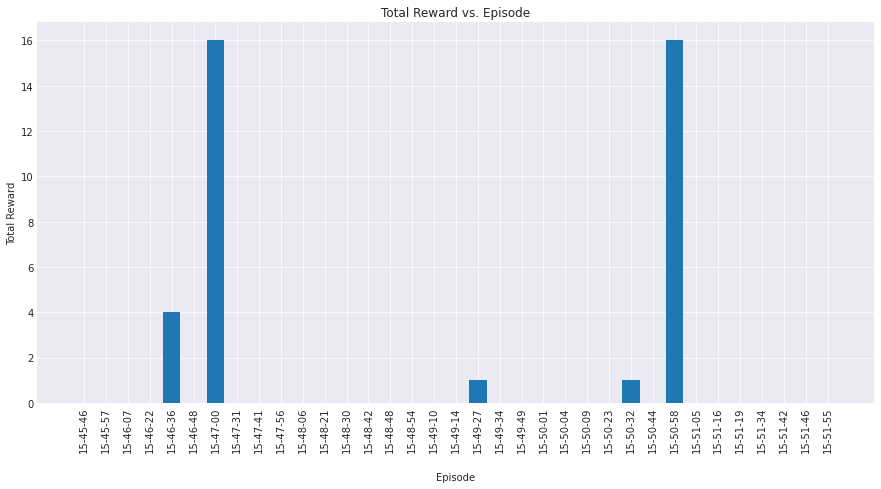

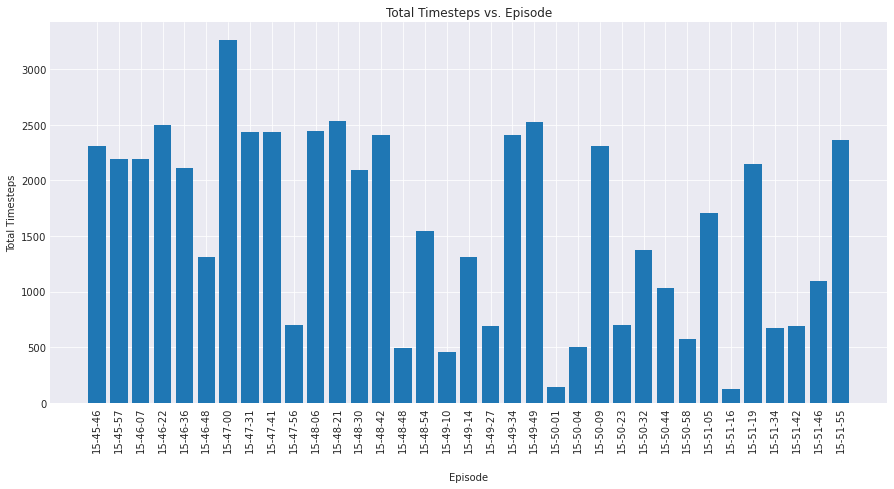

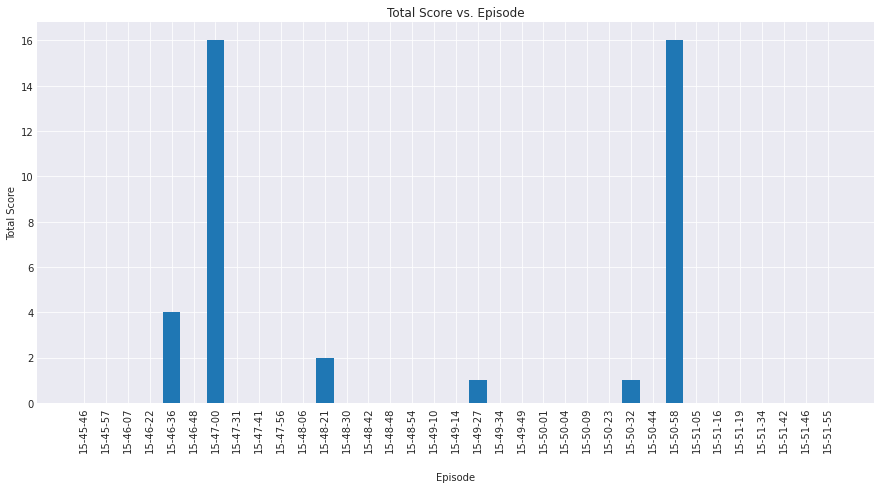

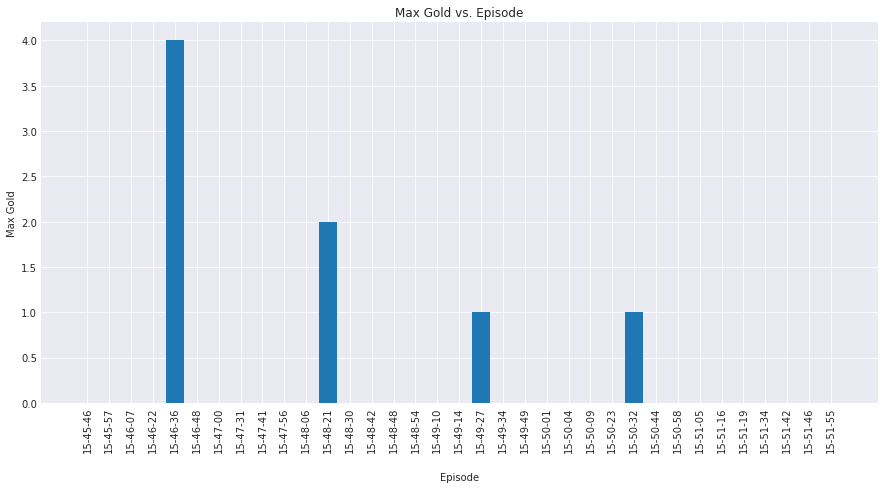

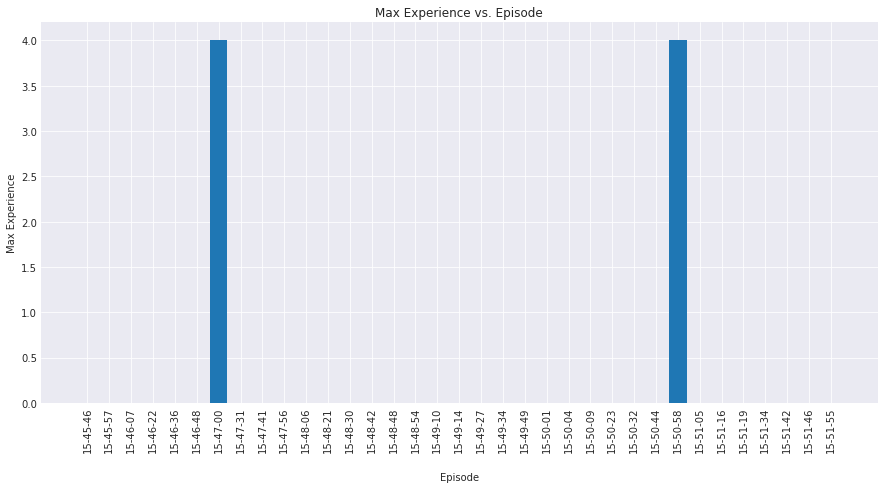

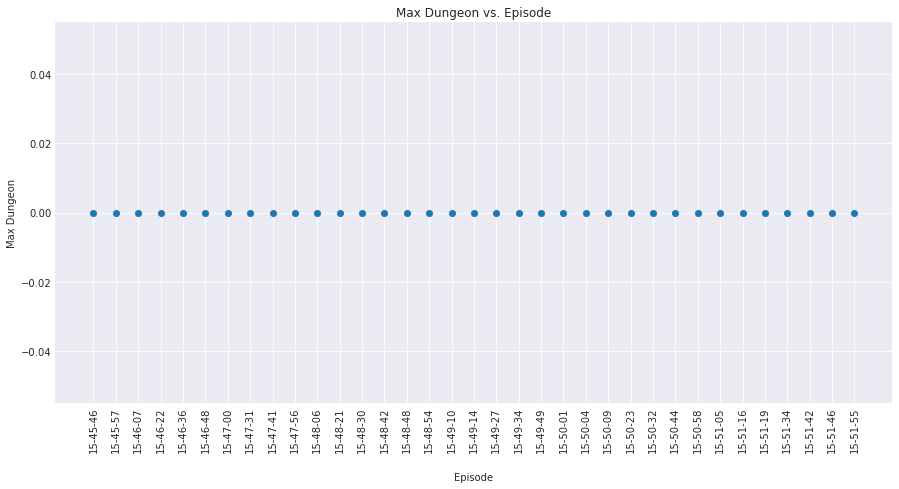

In [17]:
%%time
MAX_STEPS = 1000000

obs = env.reset()

for t in range(MAX_STEPS):
    state = concat_state(obs)
    
    # Select and perform an action
    action = select_action(state)
    obs, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # Keep track of current state and previous states 
    last_state = state
    state = concat_state(obs)

    # Store the transition in memory
    memory.push(last_state, action, state, reward)

    # Perform one step of the optimization (on the policy network)
    optimize_model(t)

    if done:
        obs = env.reset()
    # Update the target network, copying all weights and biases in DQN
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
print('Complete')
env.write_report()

In [18]:
torch.save(policy_net, 'policy-custom-reward-valk-2')
torch.save(target_net, 'target-custom-reward-valk-2')

# 3,0000,000 steps

In [19]:
env = NetHackMetricsEnv('DQN-Final-Valk-3', character='valkyrie-dwarf')
n_actions = env.action_space.n

In [20]:
"""
Loads the data if there is need for it. 
Should only be ran if we trained without testing and vice versa. 
"""
policy_net = torch.load('policy-custom-reward-valk-2')
policy_net.eval()
target_net = torch.load('target-custom-reward-valk-2')
target_net.eval()

DQNetwork(
  (joe): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=(0, 1), dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=(1, 0), dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1728, out_features=192, bias=True)
    (8): ReLU()
    (9): Linear(in_features=192, out_features=45, bias=True)
  )
)

Iteration number 0 loss: 0.0016530578723177314
Iteration number 10000 loss: 0.0016526683466508985
Iteration number 20000 loss: 0.001657871762290597
Iteration number 30000 loss: 0.0016537174815312028
Iteration number 40000 loss: 0.0016506321262568235
Iteration number 50000 loss: 0.0017055126372724771
Iteration number 60000 loss: 0.0016772462986409664
Iteration number 70000 loss: 0.001656802138313651
Iteration number 80000 loss: 0.0016813375987112522
Iteration number 90000 loss: 0.0016959409695118666
Iteration number 100000 loss: 0.0017158272676169872
Iteration number 110000 loss: 0.0017251204699277878
Iteration number 120000 loss: 0.0017140890704467893
Iteration number 130000 loss: 0.001740443054586649
Iteration number 140000 loss: 0.0016568155260756612
Iteration number 150000 loss: 0.0017527069430798292
Iteration number 160000 loss: 0.001668533543124795
Iteration number 170000 loss: 0.0016887943493202329
Iteration number 180000 loss: 0.0016747335903346539
Iteration number 190000 loss: 

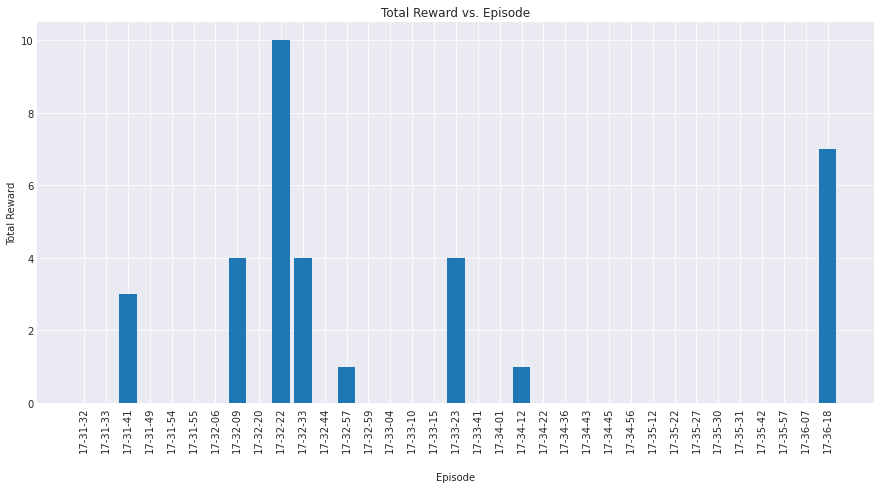

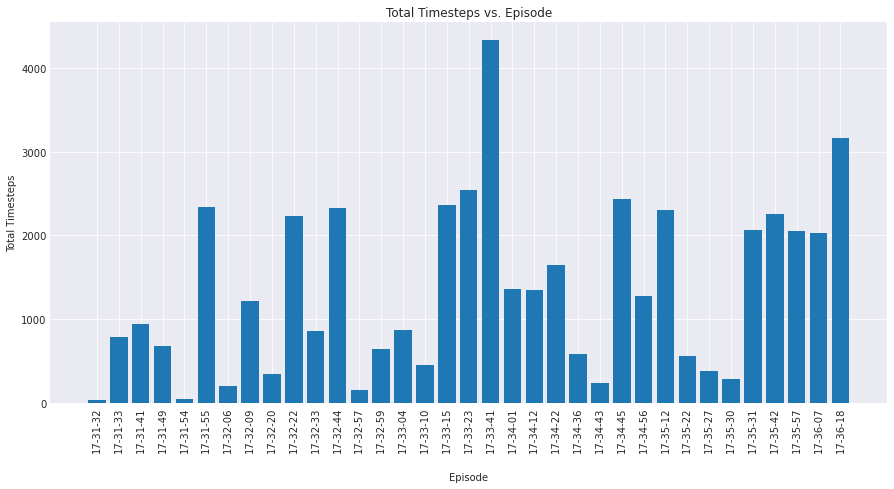

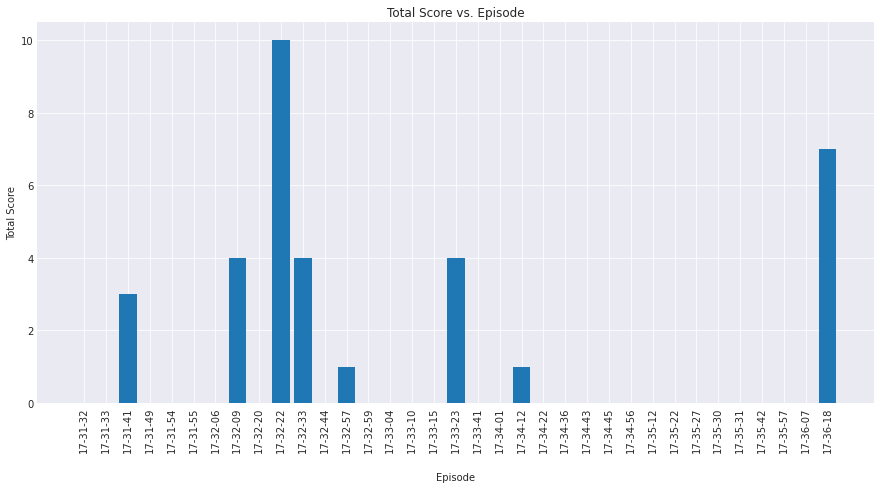

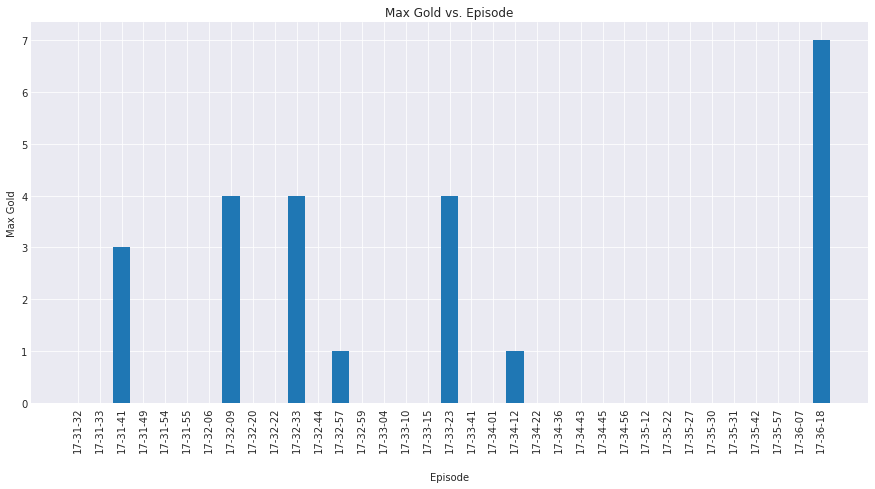

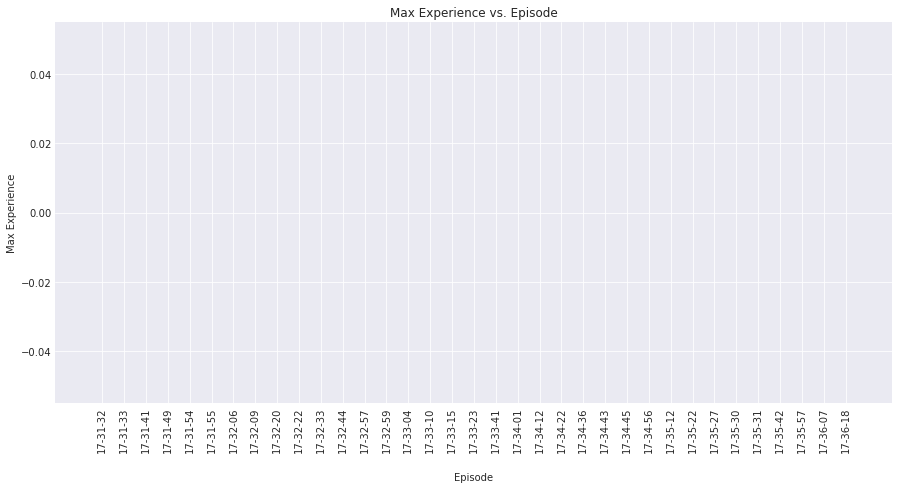

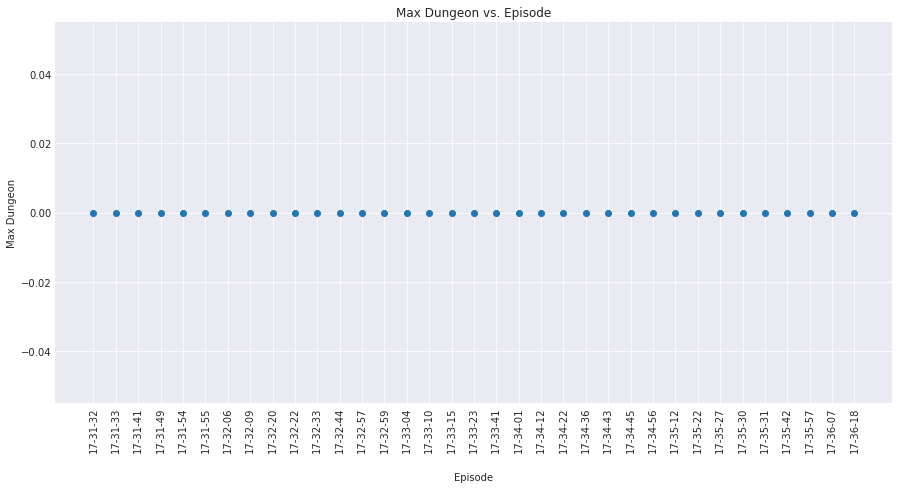

In [21]:
%%time
MAX_STEPS = 1000000

obs = env.reset()

for t in range(MAX_STEPS):
    state = concat_state(obs)
    
    # Select and perform an action
    action = select_action(state)
    obs, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # Keep track of current state and previous states 
    last_state = state
    state = concat_state(obs)

    # Store the transition in memory
    memory.push(last_state, action, state, reward)

    # Perform one step of the optimization (on the policy network)
    optimize_model(t)

    if done:
        obs = env.reset()
    # Update the target network, copying all weights and biases in DQN
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
print('Complete')
env.write_report()

In [22]:
torch.save(policy_net, 'policy-custom-reward-valk-3')
torch.save(target_net, 'target-custom-reward-valk-3')

# Training another million

In [ ]:
"""
Testing code will go below here
"""

# Training another million

In [ ]:
"""
Testing code will go below here
"""